<a href="https://colab.research.google.com/github/anikch/paddy/blob/main/Code2_Paddy_VGG16_exp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install keras_cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from functools import partial
import posixpath
from keras import models, regularizers, layers, optimizers, losses, metrics
import keras_cv
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!nvidia-smi

Mon Oct 24 16:56:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    47W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
colab= '/content/drive/MyDrive'
local= r'G:\My Drive'

code_runtime= colab

In [5]:
tf.__version__

'2.9.2'

In [6]:
file1= 'thesis/dataset/paddy_doctor/train.csv'
inp_file = posixpath.join(code_runtime, file1)

train_table=pd.read_csv(inp_file)
train_table

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [7]:
labels=list(np.unique(train_table['label']))
labels

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [8]:
train_dir= 'thesis/dataset/paddy_doctor/train/'
val_dir= 'thesis/dataset/paddy_doctor/val/'
img_size= 224

train_files= posixpath.join(code_runtime, train_dir)
test_files= posixpath.join(code_runtime, val_dir)

train_data= tf.keras.utils.image_dataset_from_directory(train_files,
                                                        labels='inferred',
                                                        label_mode='categorical',
                                                        validation_split=0.2,
                                                        subset="training",
                                                        class_names=labels,
                                                        color_mode='rgb',
                                                        image_size=(img_size, img_size),
                                                        shuffle=True,
                                                        seed= 42,
                                                        batch_size= 16)

val_data= tf.keras.utils.image_dataset_from_directory(train_files,
                                                        labels= 'inferred',
                                                        label_mode='categorical',
                                                        validation_split=0.2,
                                                        subset="validation",
                                                        class_names= labels,
                                                        color_mode='rgb',
                                                        image_size=(img_size, img_size),
                                                        shuffle=True,
                                                        seed= 42,
                                                        batch_size= 16)


test_datagen= ImageDataGenerator()
test_data= test_datagen.flow_from_directory(test_files,
                                            target_size= (img_size, img_size),
                                            batch_size= 16,
                                            shuffle = False, 
                                            class_mode='categorical')

Found 14302 files belonging to 10 classes.
Using 11442 files for training.
Found 14302 files belonging to 10 classes.
Using 2860 files for validation.
Found 1500 images belonging to 10 classes.


In [45]:
class_names = train_data.class_names
print(class_names)

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


In [42]:
test_data.class_indices

{'bacterial_leaf_blight': 0,
 'bacterial_leaf_streak': 1,
 'bacterial_panicle_blight': 2,
 'blast': 3,
 'brown_spot': 4,
 'dead_heart': 5,
 'downy_mildew': 6,
 'hispa': 7,
 'normal': 8,
 'tungro': 9}

In [10]:
optimizer_adam_amsgrad= tf.keras.optimizers.Adam(learning_rate= 1e-4, amsgrad= True)
optimizer_adam= tf.keras.optimizers.Adam(learning_rate= 1e-4, amsgrad= False)
optimizer_sgd= tf.keras.optimizers.SGD(lr=1e-4, momentum= 0.9)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


## 1. VGG16 (No Augmentation + Training from scratch)

In [11]:
base_model= tf.keras.applications.VGG16(
    include_top= False,
    weights= None,
    input_shape=(img_size, img_size, 3),
    pooling= 'max'
)

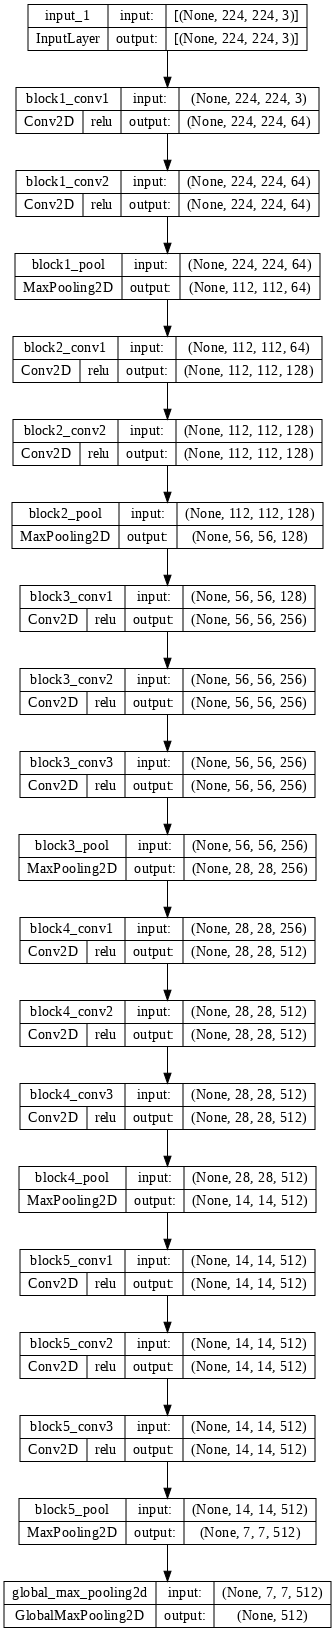

In [12]:
tf.keras.utils.plot_model(
    base_model,
    show_shapes= True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TR",
    expand_nested=False,
    dpi=72,
    layer_range=None,
    show_layer_activations=True,
)

In [13]:
inputs= tf.keras.Input(shape= (img_size, img_size, 3))
preprocess_layer= tf.keras.applications.vgg16.preprocess_input(inputs)
normalization_layer= tf.keras.layers.Rescaling(scale= 1./127.5, offset= -1)(preprocess_layer)
x= base_model(normalization_layer)
x= tf.keras.layers.Dropout(0.25)(x)
outputs= tf.keras.layers.Dense(10, activation= 'softmax')(x)

In [14]:
model= tf.keras.Model(inputs= inputs, outputs= outputs, name= "vgg16_scratch_no_augmentation")

In [15]:
model.summary()

Model: "vgg16_scratch_no_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                     

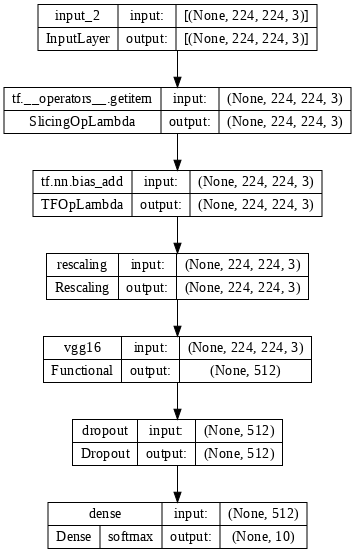

In [17]:
tf.keras.utils.plot_model(
    model,
    show_shapes= True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TR",
    expand_nested=False,
    dpi=72,
    layer_range=None,
    show_layer_activations=True,
)

In [18]:
%%time
n_epochs= 100

filepath= "weights-improvement-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint_callback= ModelCheckpoint(filepath, monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode= 'max')
early_stop_callback= EarlyStopping(monitor='val_accuracy', patience= 5, verbose= False, mode='max')
callbacks_list=[checkpoint_callback, early_stop_callback]

CPU times: user 103 µs, sys: 54 µs, total: 157 µs
Wall time: 163 µs


In [19]:
model.compile(
        optimizer = optimizer_sgd,
        loss = 'categorical_crossentropy', 
        metrics = ['accuracy', tfa.metrics.F1Score(average='macro', num_classes= 10)]
        )

In [20]:
history= model.fit(train_data,
                    epochs= n_epochs,
                    validation_data= val_data,
                    verbose= 1)

Epoch 1/100
716/716 [==============================] - 37s 44ms/step - loss: 2.3019 - accuracy: 0.1106 - f1_score: 0.0505 - val_loss: 2.3011 - val_accuracy: 0.1143 - val_f1_score: 0.0205
Epoch 2/100
716/716 [==============================] - 30s 42ms/step - loss: 2.3008 - accuracy: 0.1120 - f1_score: 0.0356 - val_loss: 2.3003 - val_accuracy: 0.1143 - val_f1_score: 0.0205
Epoch 3/100
716/716 [==============================] - 30s 42ms/step - loss: 2.3002 - accuracy: 0.1118 - f1_score: 0.0348 - val_loss: 2.2998 - val_accuracy: 0.1143 - val_f1_score: 0.0205
Epoch 4/100
716/716 [==============================] - 30s 42ms/step - loss: 2.2997 - accuracy: 0.1179 - f1_score: 0.0378 - val_loss: 2.2993 - val_accuracy: 0.1143 - val_f1_score: 0.0205
Epoch 5/100
716/716 [==============================] - 30s 42ms/step - loss: 2.2994 - accuracy: 0.1169 - f1_score: 0.0371 - val_loss: 2.2989 - val_accuracy: 0.1143 - val_f1_score: 0.0205
Epoch 6/100
716/716 [==============================] - 30s 42ms/s

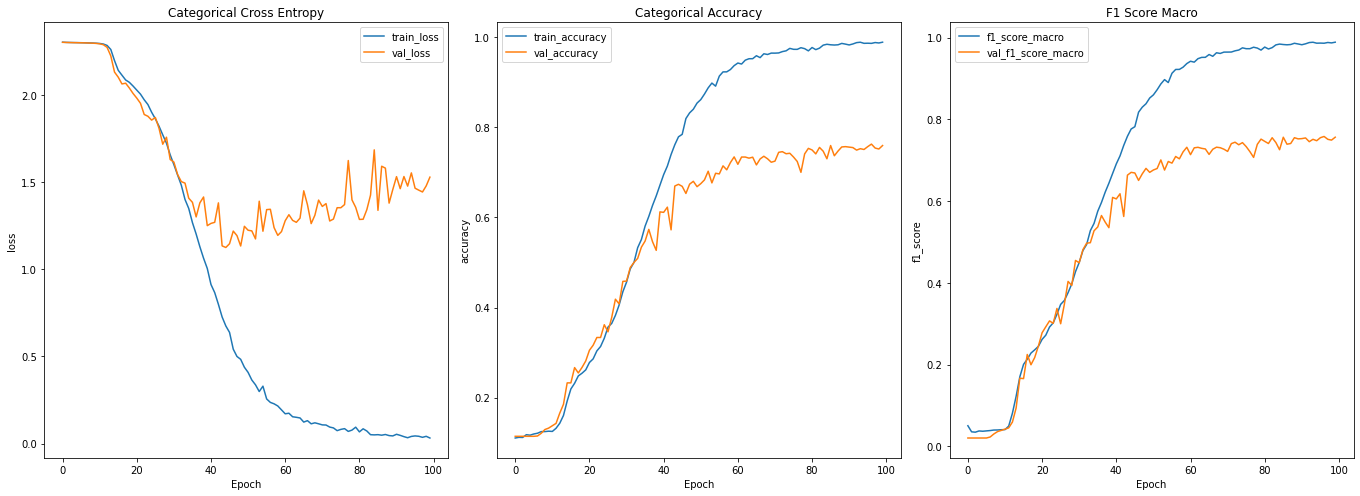

In [24]:
def plot_results(history, epochs, FE_name= "ResNet50", model_name= "ResNet50_model", version= 1):
    import os
    ## Create the dataframe
    data = pd.DataFrame()
    data["Epoch"] = [i for i in range(epochs)]
    data["loss"] = history.history["loss"]
    data["val_loss"] = history.history["val_loss"]
    data["accuracy"] = history.history["accuracy"]
    data["val_accuracy"] = history.history["val_accuracy"]
    data["f1_score"] = history.history["f1_score"]
    data["val_f1_score"] = history.history["val_f1_score"]

    ## Create subplots
    fig, ax= plt.subplots(1, 3, figsize = (19, 7))

    ## plot loss
    sns.lineplot(x= "Epoch", y= "loss", data = data, ax= ax[0])
    sns.lineplot(x= "Epoch", y= "val_loss", data = data, ax= ax[0])
    ax[0].legend(["train_loss", "val_loss"], loc= 'best')
    ax[0].title.set_text("Categorical Cross Entropy")

    ## plot accuracy
    sns.lineplot(x = "Epoch", y = "accuracy", data = data, ax = ax[1])
    sns.lineplot(x = "Epoch", y = "val_accuracy", data = data, ax = ax[1])
    ax[1].legend(["train_accuracy", "val_accuracy"], loc='best')
    ax[1].title.set_text("Categorical Accuracy")

    ## plot f1
    sns.lineplot(x = "Epoch", y = "f1_score", data = data, ax = ax[2])
    sns.lineplot(x = "Epoch", y = "val_f1_score", data = data, ax = ax[2])
    ax[2].legend(["f1_score_macro", "val_f1_score_macro"], loc='best')
    ax[2].title.set_text("F1 Score Macro")


    ## Remove padding
    fig.tight_layout()

plot_results(history, epochs = 100, FE_name = "VGG16", model_name = "VGG16_exp1")

In [39]:
test_data.classes

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [25]:
model.evaluate(test_data, batch_size= 16, return_dict= True)

94/94 [==============================] - 10s 101ms/step - loss: 1.0745 - accuracy: 0.8127 - f1_score: 0.8121


{'loss': 1.0745186805725098,
 'accuracy': 0.812666654586792,
 'f1_score': 0.8121035695075989}

In [51]:
test_data.classes

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [52]:
# Generating Confusion Matrix and Classification Report
Y_pred= model.predict_generator(test_data, 1500// 16 + 1)
y_pred= np.argmax(Y_pred, axis= 1)
print('Confusion Matrix')
conf_matrix= confusion_matrix(test_data.classes, y_pred)
conf_mat = np.array2string(conf_matrix)
#print(conf_matrix)
#print("=============================================================================================")
print('Classification Report')
target_names= test_data.class_indices
class_rep_vgg = classification_report(test_data.classes, y_pred, target_names=target_names)
print(class_rep_vgg)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Confusion Matrix
Classification Report
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.79      0.66      0.72       150
   bacterial_leaf_streak       0.87      0.85      0.86       150
bacterial_panicle_blight       0.78      0.81      0.79       150
                   blast       0.85      0.83      0.84       150
              brown_spot       0.74      0.79      0.76       150
              dead_heart       0.80      0.88      0.84       150
            downy_mildew       0.87      0.85      0.86       150
                   hispa       0.79      0.85      0.82       150
                  normal       0.86      0.83      0.84       150
                  tungro       0.78      0.78      0.78       150

                accuracy                           0.81      1500
               macro avg       0.81      0.81      0.81      1500
            weighted avg       0.81      0.81      0.81      1500



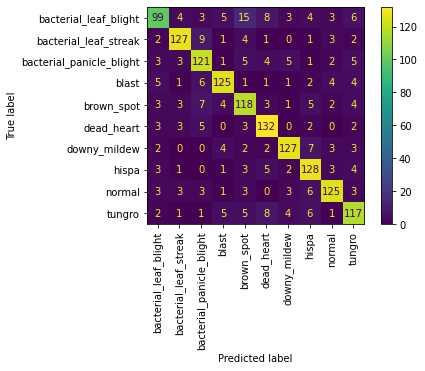

In [53]:
ConfusionMatrixDisplay.from_predictions(test_data.classes, y_pred, display_labels= target_names, xticks_rotation= 'vertical')